# Exploratory Data Analysis (EDA) 

In [1]:
# TO DO PRIO 1: Make sure the extraction of salaries is working, even with decimals. 

# Vectorization 

# TO DO: fix requirements.txt file 

# Is this causing big problems later on? 
# df['column_name'] = df['column_name'].astype('category')

# Something is iffy with nltk and stopwords being loaded several times

In [2]:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('system_profiler').setLevel(logging.ERROR)

In [3]:
# Standard library imports 
import os
import sys 

# Third-party imports 
#import langdetect as ld
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Local imports 
import utils.preprocessor as mf
import utils.plotting as pf
import utils.text_parser as tf
#import utils.salary_extractor as sf
import utils.salary_extraction as sf2
import utils.dictionaries as dicts

# Activate autoreload for custom modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

# File path definitions
DATA_PATH = os.getenv('DATA_PATH', 'data/')  # Use env variable or default
MISSING = os.path.join(DATA_PATH, 'df_FRA_missing_data.csv')
         
COUNTRIES = ['Sweden', 'France', 'Italy']

[nltk_data] Downloading package punkt to /Users/emmafrid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/emmafrid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Check we're in the right environment
print(sys.executable)

/Users/emmafrid/Documents/GitHub/portfolio-projects/job-listings-scraper/salary_env/bin/python


## Load data
Import the data scraped using scraper-countries.py (Sept 20-21 2024), for the following countries: USA, Sweden, France, and Italy. These datasets contain the job listings for the 3 largest cities in respective country, for the job titles _Data Scientist_, _Data Analyst_, _Product Analyst_, and _BI Analyst_.

In [5]:
# Import csv files with scraped data for resp. country 
dfs = {
    country: pd.read_csv(os.path.join(DATA_PATH, f'indeed_jobs_{country}.csv'))
    for country in COUNTRIES
}

# Add USA data to the dictionary
dfs['USA'] = mf.merge_US_cities(['NY', 'LA', 'CHI'], os.path.join(DATA_PATH, 'indeed_jobs_'))

# Access individual country data as needed, e.g., dfs['Sweden']

Loaded data for NY
Column order for consistency: ['page', 'country', 'job_link', 'search_keyword', 'search_location', 'job_title', 'company_name', 'company_location', 'salary', 'job_description']


## Initial data inspection

In [6]:
dfs['Sweden'].head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data+Analyst,Stockholm,Data Analyst (Data Visualization),Swedium Global Services,Distansjobb in Stockholm,Not available,Data Analyst (Data Visualization) \n \n Swediu...
1,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd8...,Data+Analyst,Stockholm,Data Analyst,Deploja AB,169 73 Solna,Not available,Role: \n \n Website Performance: Web analyst f...
2,1,Sweden,https://se.indeed.com/rc/clk?jk=07cc3fa43334c5...,Data+Analyst,Stockholm,Data Analyst,Cubane Solutions AB,Stockholm,Heltid,Responsibilities \n \n Website Performance: W...
3,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data+Analyst,Stockholm,Data Analyst,Sobi,Stockholm,Heltid,Company Description \n Statistics show that w...
4,1,Sweden,https://se.indeed.com/rc/clk?jk=65bfa8c313624f...,Data+Analyst,Stockholm,"Juniora Analysts till Operations, Engineering,...",Deloitte,113 57 Stockholm,Heltid,Företagsbeskrivning \n \n \n Deloitte är en g...


In [7]:
dfs['France'].head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,France,https://www.indeed.fr/rc/clk?jk=3163cc1d8a51ee...,Data+Analyst,Paris (75),CDI - Data analyst KYC - Senior F/H,La Banque Postale,Paris (75),CDI,INTRODUCTION \n Au sein de la direction Data ...
1,1,France,https://www.indeed.fr/rc/clk?jk=71fa252714d41c...,Data+Analyst,Paris (75),Data Analyst F/H,IZI Solutions Durables,Télétravail partiel à La Défense (92),CDI,"À propos \n \n En 2019, le Groupe EDF veut re..."
2,1,France,https://www.indeed.fr/rc/clk?jk=21f25c16a32522...,Data+Analyst,Paris (75),Data analyst,Le Groupe La Poste,Issy-les-Moulineaux (92),CDI,"La Poste Groupe change, nos métiers évoluent. ..."
3,1,France,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,Paris (75),Data Analyst H/F,GROUPE ID SEARCH,Paris (75),"À partir de 35 000 € par an - CDI, Temps plein","Tertialis, société du groupe ID SEARCH, est sp..."
4,1,France,https://www.indeed.fr/rc/clk?jk=8c5cc311877c09...,Data+Analyst,Paris (75),Consultant Débutant Data Analyst en CDI - Pari...,EY,92037 La Défense,CDI,Participer à la digitalisation de nos clients ...


In [8]:
dfs['Italy'].head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Business Intelligence (Power BI) - Python- Bus...,Area IT Group,"Roma, Lazio",25.000 € - 40.000 € all'anno,Ricerchiamo Sviluppatori in almeno uno dei seg...
1,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Power Bi Analyst,Verisure Italy,00144 Roma,Not available,Ti piacerebbe far parte della multinazionale d...
2,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",IT Project Management Internship,Procter & Gamble,"Roma, Lazio",Not available,Job Location Rome Job Description INFORMATI...
3,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Credit & Collection Data Analyst,Verisure Italy S R L,00144 Roma,Not available,Ti piacerebbe far parte della multinazionale d...
4,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Aeronautical System Analyst,adecco,"Roma, Lazio",Not available,Per azienda leader a livello globale nella ges...


In [9]:
dfs['USA'].head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,USA,https://www.indeed.com/rc/clk?jk=5bf7eb172149d...,Data+Analyst,"New+York, NY",Business Analyst (Data products),Aon,"Remote in New York, NY","$80,000 - $95,000 a year - Full-time","Senior Associate Consultant, Data Solutions ..."
1,1,USA,https://www.indeed.com/rc/clk?jk=6b99bd10f1316...,Data+Analyst,"New+York, NY",Data Analyst,NYU Langone,"New York, NY",$32.38 - $39.01 an hour - Temporary,NYU Grossman School of Medicine is one of the...
2,1,USA,https://www.indeed.com/rc/clk?jk=d70c515431fa2...,Data+Analyst,"New+York, NY",Data Analyst,NYU Langone Health,"New York, NY 10016","$67,771.14 - $75,000.00 a year - Full-time",NYU Grossman School of Medicine is one of the...
3,1,USA,https://www.indeed.com/rc/clk?jk=3aa26222eadd6...,Data+Analyst,"New+York, NY","Resy Marketing Data Analyst, Data and Analytics",Amex,"Hybrid work in New York, NY","$60,000 - $110,000 a year",You Lead the Way. We’ve Got Your Back. \n With...
4,1,USA,https://www.indeed.com/rc/clk?jk=3aa564ce173c8...,Data+Analyst,"New+York, NY",2025 University Graduate - Digital Strategy An...,Adobe,"New York, NY 10012","$53,900 - $101,450 a year - Full-time",Our Company Changing the world through digit...


### Check dimensions and data types

In [10]:
# Check dimensions of dfs 
for country, df in dfs.items(): 
    print(f'{country} \t   columns: {dfs[country].shape[1]} \t  rows: {dfs[country].shape[0]}')

Sweden 	   columns: 10 	  rows: 320
France 	   columns: 10 	  rows: 2200
Italy 	   columns: 10 	  rows: 769
USA 	   columns: 10 	  rows: 1317


In [11]:
# Check data types
dfs['Sweden'].info() 
# Convert columns with strings only to string data type to optimize performance
# Mixed columns with both numbers and strings that should be kept as object: company_location, salary, job_link (url)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   page              320 non-null    int64 
 1   country           320 non-null    object
 2   job_link          320 non-null    object
 3   search_keyword    320 non-null    object
 4   search_location   320 non-null    object
 5   job_title         320 non-null    object
 6   company_name      320 non-null    object
 7   company_location  320 non-null    object
 8   salary            320 non-null    object
 9   job_description   320 non-null    object
dtypes: int64(1), object(9)
memory usage: 25.1+ KB


In [12]:
dicts.dtype_dict

{'page': 'int64',
 'country': 'string',
 'job_link': 'object',
 'search_keyword': 'category',
 'search_location': 'string',
 'job_title': 'string',
 'company_name': 'string',
 'company_location': 'object',
 'salary': 'object',
 'job_description': 'string'}

In [13]:
# Convert columns to the correct data types 
for country, df in dfs.items():
    dfs[country] = dfs[country].astype(dicts.dtype_dict)

print(dfs['Sweden'].dtypes)

page                         int64
country             string[python]
job_link                    object
search_keyword            category
search_location     string[python]
job_title           string[python]
company_name        string[python]
company_location            object
salary                      object
job_description     string[python]
dtype: object


In [14]:
dfs['Sweden'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   page              320 non-null    int64   
 1   country           320 non-null    string  
 2   job_link          320 non-null    object  
 3   search_keyword    320 non-null    category
 4   search_location   320 non-null    string  
 5   job_title         320 non-null    string  
 6   company_name      320 non-null    string  
 7   company_location  320 non-null    object  
 8   salary            320 non-null    object  
 9   job_description   320 non-null    string  
dtypes: category(1), int64(1), object(3), string(5)
memory usage: 23.1+ KB


### Conclusions
- The following columns needs to be cleaned: search_keyword, job_title, job_description, company_location.   
- The salary column should be split into two columns (separate numeric vs string content).    

## Data Quality Assessment
Data reduction and data cleaning

### Missing values

In [15]:
# The scraper labels cells as 'Not available' when there is no value. Change these to NaN. 
for country, df in dfs.items():
    df.replace('Not available', np.nan, inplace=True)
    nan_counts = df.isnull().sum()
    #nan_percentage = df.isnull().mean()*100
    print(f'Missing values for {country}:')
    print(f'{nan_counts}\n')

Missing values for Sweden:
page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              183
job_description       0
dtype: int64

Missing values for France:
page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description      51
dtype: int64

Missing values for Italy:
page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              746
job_description       0
dtype: int64

Missing values for USA:
page                 0
country              0
job_link             0
search_keyword       0
search_location      0
job_title          

Salary entries will be examined more in detail later when columns are split.  For now we do not drop these rows (we are not primarily interested in salaries). 

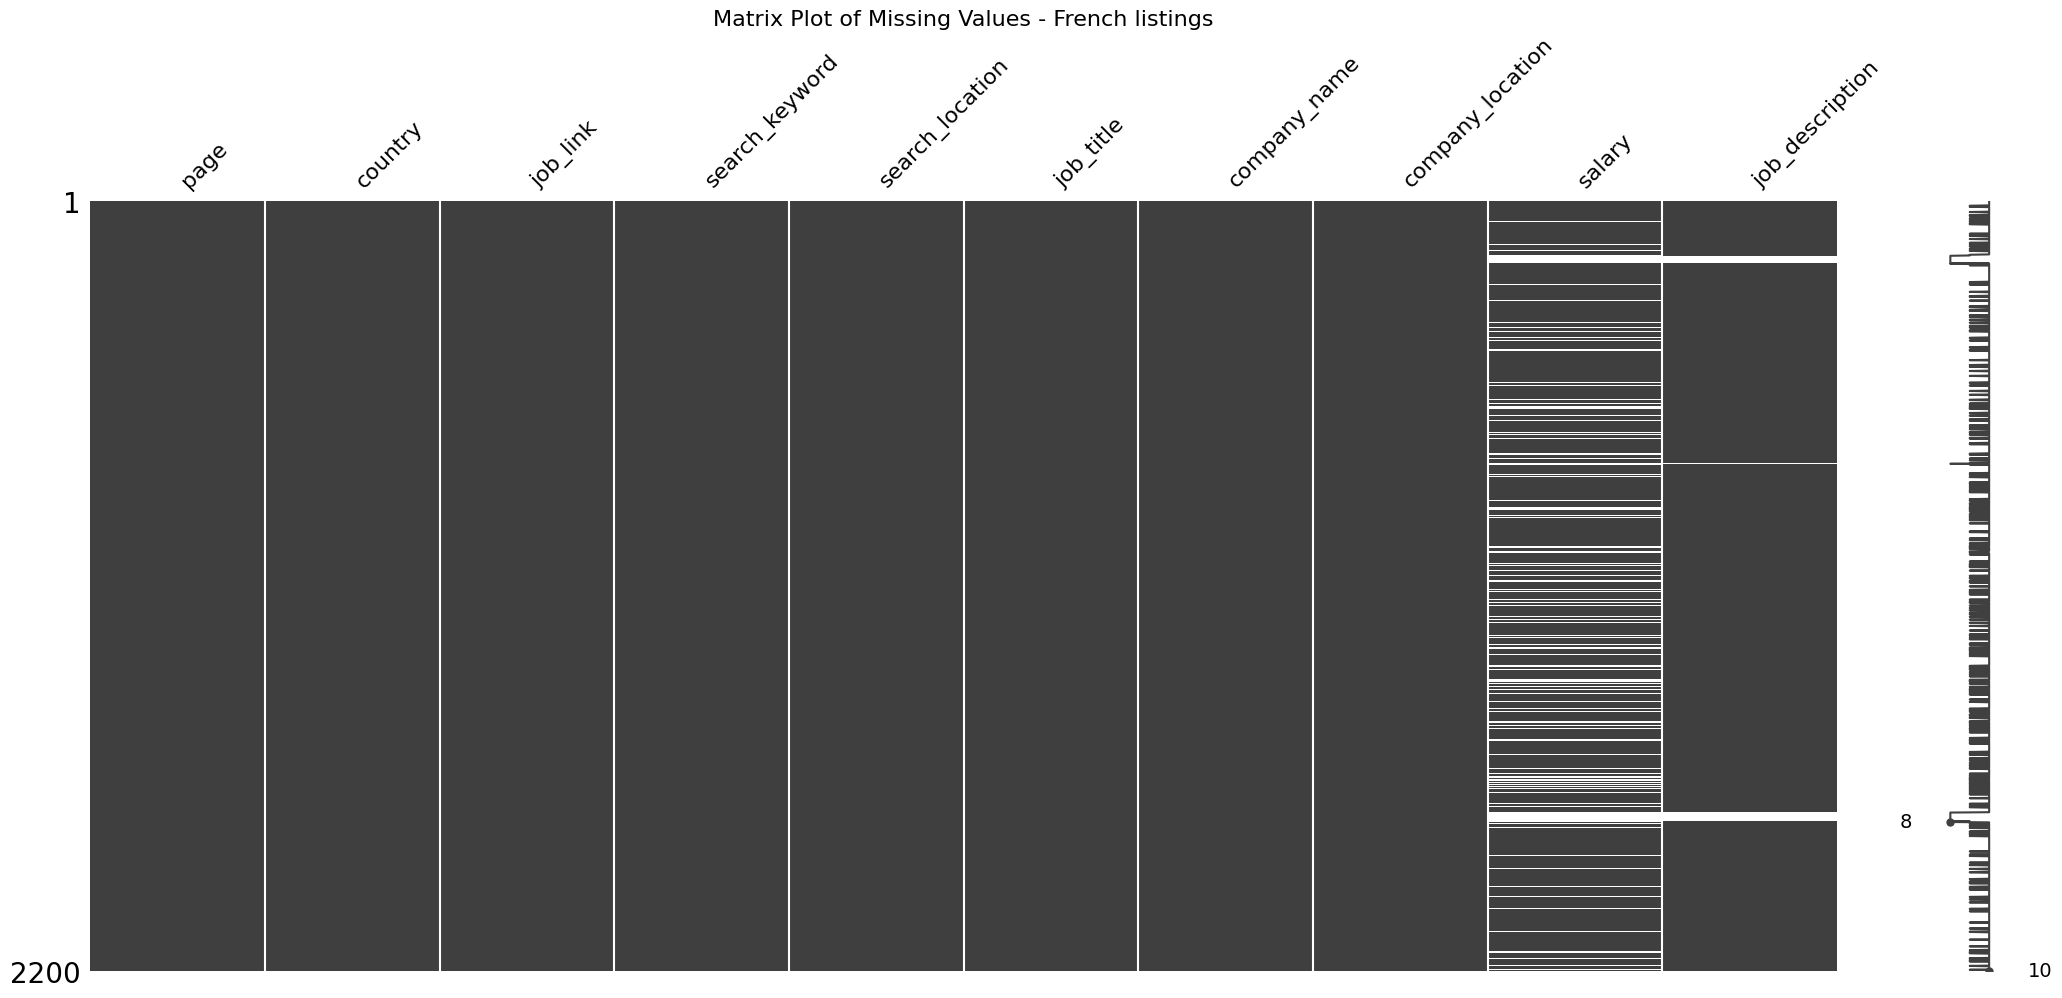

In [16]:
# Visualize missing data patterns using missingno
msno.matrix(dfs['France']) #.sample(250)
plt.title('Matrix Plot of Missing Values - French listings', fontsize=16) 
plt.show()

In [17]:
# Look into the missing descriptions for French job listings (seems that scraper requests were blocked here?)
print(dfs['France'].isnull().sum())
dfs['France'][dfs['France']['job_description'].isnull()].head()

# Manual imports of missing job descriptions from URLs 
df_FRA_missing = pd.read_csv(MISSING)

page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description      51
dtype: int64


In [18]:
# Merge the DataFrames based on the 'job_link' column
merged_df = pd.merge(dfs['France'], df_FRA_missing[['job_link', 'job_description_new']], on='job_link', how='left')

# Use combine_first to fill 'job_description' column more efficiently
merged_df['job_description'] = merged_df['job_description'].combine_first(merged_df['job_description_new'])

# Drop 'job_description_new' column efficiently
merged_df.drop(columns='job_description_new', inplace=True)

# Verify that there are no missing values in 'job_description'
merged_df.isnull().sum()
dfs['France'] = merged_df
print(dfs['France'].isnull().sum())

page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description       0
dtype: int64


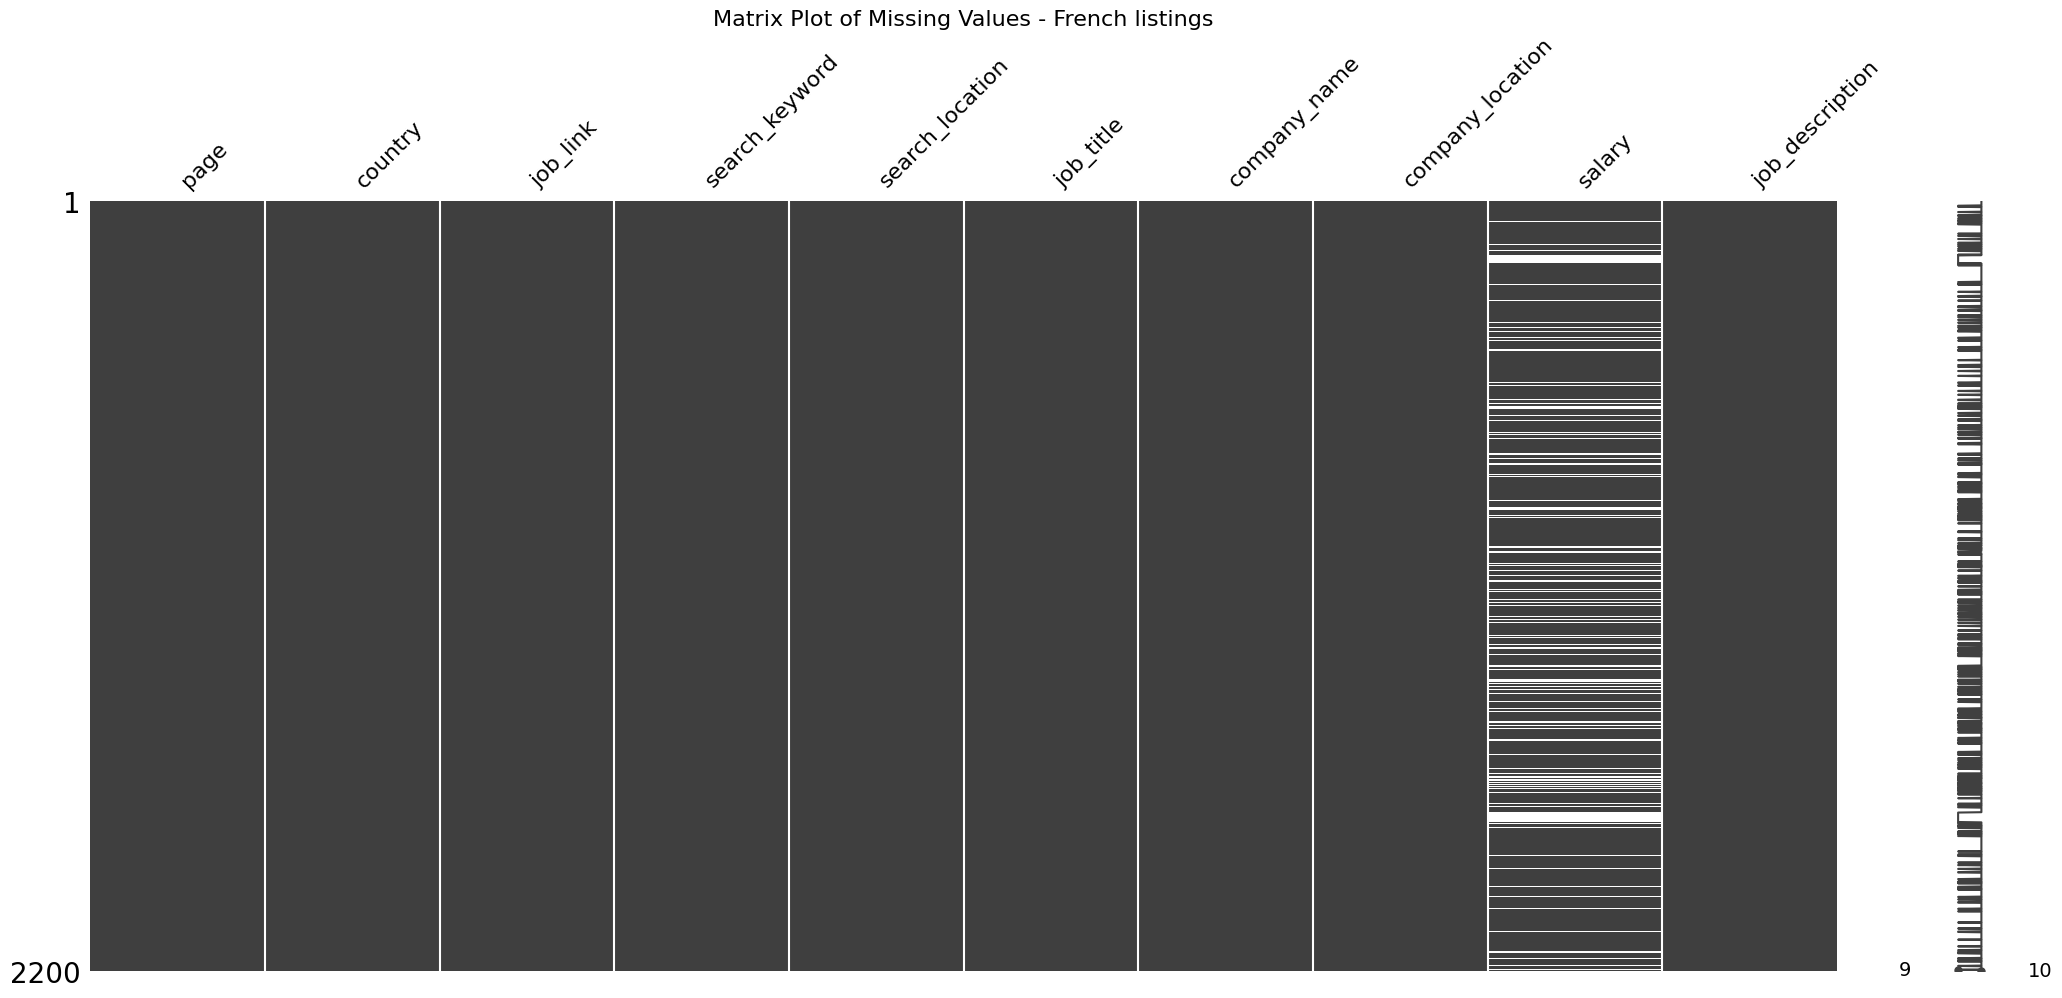

In [19]:
# Now the job_description should not have missing values anymore
msno.matrix(dfs['France']) #.sample(250)
plt.title('Matrix Plot of Missing Values - French listings', fontsize=16)  
plt.show()

In [20]:
# Make sure all data types are the same after adding info from CSV
dfs['France'] = dfs['France'].astype(dicts.dtype_dict)
print(dfs['France'].dtypes)

page                         int64
country             string[python]
job_link                    object
search_keyword            category
search_location     string[python]
job_title           string[python]
company_name        string[python]
company_location            object
salary                      object
job_description     string[python]
dtype: object


In [21]:
# There are still many missing values for salary
# This information was not always provided in the job listings
dfs['France']['salary'].isnull().sum()

np.int64(378)

### Check for duplicates

In [22]:
# Check for potential duplicates 
for country, df in dfs.items():
    print(f'Duplicates for {country} :')
    mf.check_duplicates(df)
    print('\n')

Duplicates for Sweden :
The DataFrame has 320 rows.
Empty DataFrame
Columns: [page, country, job_link, search_keyword, search_location, job_title, company_name, company_location, salary, job_description]
Index: []


Duplicates for France :
The DataFrame has 2200 rows.
Empty DataFrame
Columns: [page, country, job_link, search_keyword, search_location, job_title, company_name, company_location, salary, job_description]
Index: []


Duplicates for Italy :
The DataFrame has 769 rows.
Empty DataFrame
Columns: [page, country, job_link, search_keyword, search_location, job_title, company_name, company_location, salary, job_description]
Index: []


Duplicates for USA :
The DataFrame has 1317 rows.
Empty DataFrame
Columns: [page, country, job_link, search_keyword, search_location, job_title, company_name, company_location, salary, job_description]
Index: []




No rows are completely identical, but perhaps there are <i>job descriptions</i> that are identical? 

In [23]:
# Identify duplicates (same job title, location, and job description, and keep only the latest job listing(
for country, df in dfs.items():
    df = mf.remove_duplicates_jobdesc(df) 

There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 3200. Size after removing duplicates: 2630 

There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 22000. Size after removing duplicates: 13650 

There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 7690. Size after removing duplicates: 5690 

There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 13170. Size after removing duplicates: 8350 



There are numerous examples of completely identical job descriptions. These are likely reposts (the same job appearing multiple times, just with different unique links!). 
<b>Remove these entries if the job titles are the same and the locations are the same.</b> 

### Clean columns

In [24]:
# Clean search_keyword and search_location columns: replace '+' with ' ' 
for country, df in dfs.items():
    # Convert to string 
    df['search_keyword'] = df['search_keyword'].astype(str)    
    df['search_location'] = df['search_location'].astype(str)    
    # Replace '+' with ' '
    df['search_keyword'] = df['search_keyword'].str.replace('+', ' ')
    df['search_location'] = df['search_location'].astype(str)    
    # Convert back to a categorical 
    df['search_keyword'] = pd.Categorical(df['search_keyword'])
    df['search_location'] = pd.Categorical(df['search_location'])

# Verify that it worked 
dfs['Sweden'].head(3)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data Analyst,Stockholm,Data Analyst (Data Visualization),Swedium Global Services,Distansjobb in Stockholm,NaN,Data Analyst (Data Visualization) Swedium ...
1,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd8...,Data Analyst,Stockholm,Data Analyst,Deploja AB,169 73 Solna,NaN,Role: Website Performance: Web analyst foc...
2,1,Sweden,https://se.indeed.com/rc/clk?jk=07cc3fa43334c5...,Data Analyst,Stockholm,Data Analyst,Cubane Solutions AB,Stockholm,Heltid,Responsibilities Website Performance: Web...


In [25]:
# Clean job_title column 
for country, df in dfs.items():
    df['job_title'] = df['job_title'].str.lower()

    # Handle French-specific cleaning
    if country == 'France':
        df['job_title'] = df['job_title'].str.replace(r'\(?(h/f|f/h)\)?', '', regex=True).str.strip()

dfs['France']['job_title']

0                         cdi - data analyst kyc - senior
1                                            data analyst
2                                            data analyst
3                                            data analyst
4       consultant débutant data analyst en cdi - pari...
                              ...                        
2195                    commercial performance data owner
2196    consultant en gestion et gouvernance de l'info...
2197                                               devops
2198                                            tech lead
2199    senior financial data analyst | deals (m&a) | ...
Name: job_title, Length: 2200, dtype: string

In [26]:
# Clean job_description column 
# TO DO 

## Descriptive statistics

In [27]:
# Describe (numerical) columns  
dfs['France'].describe(include='all').head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,2200.000000,2200,2200,2200,2200,2200,2200,2200,1822,2200
unique,NaN,1,2200,4,3,1153,718,256,164,1355
top,NaN,France,https://www.indeed.fr/rc/clk?jk=87348216f5b0a7...,Data Analyst,Paris (75),data analyst,AXA,Paris (75),Temps plein,Line of Service Advisory \n \n Industry/Sect...
freq,NaN,2200,1,757,1949,96,64,582,512,16
mean,17.454091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# Describe categorical columns  
mf.desc_categorical(dfs['France'])

Value counts for column: country
country
France    2200
Name: count, dtype: Int64

Value counts for column: job_title
job_title
data analyst                                             96
data scientist                                           40
business analyst                                         18
data analyst intern                                      17
senior product data analyst                              13
                                                         ..
alternant(e) sales & operations planning (s&op)           1
mlops engineer                                            1
data ingénieur                                            1
analyste fp&a senior /nb                                  1
consultant en gestion et gouvernance de l'information     1
Name: count, Length: 1153, dtype: Int64

Value counts for column: company_name
company_name
AXA                   64
PwC                   27
HERMES SELLIER        25
Capgemini             24
VINCI Construction  

### Preliminary observations, Swedish job listings:
- __Most frequent job titles__: Systemutvecklare, Data Analyst, Data Scientist.
- __Most frequent company__: Cubane Solutions AB. 
- __Company location__: Stockholm primarily. 
- __Salary ranges__: Few numerical values are provided.

In [29]:
dfs['France'].describe(include='all').head(4)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,2200.0,2200,2200,2200,2200,2200,2200,2200,1822,2200
unique,NaN,1,2200,4,3,1153,718,256,164,1355
top,NaN,France,https://www.indeed.fr/rc/clk?jk=87348216f5b0a7...,Data Analyst,Paris (75),data analyst,AXA,Paris (75),Temps plein,Line of Service Advisory \n \n Industry/Sect...
freq,NaN,2200,1,757,1949,96,64,582,512,16


In [30]:
mf.desc_categorical(dfs['France']) 

Value counts for column: country
country
France    2200
Name: count, dtype: Int64

Value counts for column: job_title
job_title
data analyst                                             96
data scientist                                           40
business analyst                                         18
data analyst intern                                      17
senior product data analyst                              13
                                                         ..
alternant(e) sales & operations planning (s&op)           1
mlops engineer                                            1
data ingénieur                                            1
analyste fp&a senior /nb                                  1
consultant en gestion et gouvernance de l'information     1
Name: count, Length: 1153, dtype: Int64

Value counts for column: company_name
company_name
AXA                   64
PwC                   27
HERMES SELLIER        25
Capgemini             24
VINCI Construction  

### Preliminary observations, French job listings:
- Many listings compared to Sweden. 
- __Most frequent job titles__: Data Analyst (many similar names for this title, e.g. Data Analyst H/F and Data Analyst Intern). 
- __Most frequently mentioned company__: AXA.
- __Company location__: Most in Paris. Includes some information about télétravail (especially common in Paris).  
- __Salary ranges__: Need to split column to be able to draw any conclusions.

In [31]:
dfs['Italy'].describe(include='all').head(4)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,769.0,769,769,769,769,769,769,769,23,769
unique,NaN,1,769,4,3,454,309,96,14,554
top,NaN,Italy,https://it.indeed.com/rc/clk?jk=46de7544ab716b...,Data Analyst,"Milano, Lombardia",data scientist,BIP - Business Integration Partners,"Milano, Lombardia",52.246 € all'anno,Company: TELEPASS ASSICURA\n \n \n \n \n ...
freq,NaN,769,1,419,540,34,39,207,7,5


In [32]:
mf.desc_categorical(dfs['Italy']) 

Value counts for column: country
country
Italy    769
Name: count, dtype: Int64

Value counts for column: job_title
job_title
data scientist                                                       34
data analyst                                                         29
business analyst                                                     19
senior data analyst                                                  11
cyber security analyst                                                6
                                                                     ..
process analyst                                                       1
business analyst trainee                                              1
supply chain analyst - con inglese                                    1
market analyst                                                        1
front end data analyst - area artificial intelligence & analytics     1
Name: count, Length: 454, dtype: Int64

Value counts for column: company_name
comp

### Preliminary observations, Italian job listings:
- Many listings compared to Sweden, but less than France.
- __Most frequent job titles__: Data Analyst, Data Scientist, Business Analyst. 
- __Most frequently mentioned company__: BIP - Business Integration Partners. 
- __Company location__: Milano. Also remote in Milano is relatively common (as is Rome).
- __Salary ranges__: Very few numerical entries provided. 

In [33]:
dfs['USA'].describe(include='all').head(4)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,1317.0,1317,1317,1317,1317,1317,1317,1317,1230,1317
unique,NaN,1,1317,4,3,737,470,185,524,823
top,NaN,USA,https://www.indeed.com/rc/clk?jk=274ddb9b95715...,Data Analyst,"New+York, NY",data analyst,Citi,"New York, NY",Full-time,~Hybrid Work Schedule consists of reporting to...
freq,NaN,1317,1,522,771,29,44,269,236,6


In [34]:
mf.desc_categorical(dfs['USA']) 

Value counts for column: country
country
USA    1317
Name: count, dtype: Int64

Value counts for column: job_title
job_title
data analyst                                           29
business analyst                                       25
senior business analyst                                19
senior machine learning engineer                       14
senior data analyst                                    11
                                                       ..
senior business process analyst, premium accounting     1
sr agriculture business line manager analyst            1
business systems analyst - salesforce                   1
business analyst iv                                     1
third party risk reporting analyst                      1
Name: count, Length: 737, dtype: Int64

Value counts for column: company_name
company_name
Citi                        44
JPMorganChase               25
Publicis Sapient            18
Google                      15
Amazon.com Services LL

### Preliminary observations, American job listings:
- Number of listings are less than for France. 
- __Most frequent job titles__: Data Analyst, BI analyst, (Senior) Data Scientist. Interesting that Machine Learning Engineer shows up. Might need to cluster similar terms to get full picture (e.g. remove Senior etc.). 
- __Most frequently mentioned company__: Citi. 
- __Company location__: New York.  
- __Salary ranges__: Need to split column to draw conclusions. 

## Feature engineering 

In [35]:
# Merge all dfs in the dictionary into a single df
df_combined = pd.concat(dfs.values(), ignore_index=True)
df_combined.reset_index(drop=True, inplace=True)
# Add dates when data was scraped 
df_combined['date'] = np.where(df_combined['country'].isin(['Sweden', 'USA']), pd.to_datetime('2024-09-19'), pd.to_datetime('2024-09-20'))

df_combined.head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date
0,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data Analyst,Stockholm,data analyst (data visualization),Swedium Global Services,Distansjobb in Stockholm,NaN,Data Analyst (Data Visualization) Swedium ...,2024-09-19
1,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd8...,Data Analyst,Stockholm,data analyst,Deploja AB,169 73 Solna,NaN,Role: Website Performance: Web analyst foc...,2024-09-19
2,1,Sweden,https://se.indeed.com/rc/clk?jk=07cc3fa43334c5...,Data Analyst,Stockholm,data analyst,Cubane Solutions AB,Stockholm,Heltid,Responsibilities Website Performance: Web...,2024-09-19
3,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data Analyst,Stockholm,data analyst,Sobi,Stockholm,Heltid,Company Description Statistics show that wo...,2024-09-19
4,1,Sweden,https://se.indeed.com/rc/clk?jk=65bfa8c313624f...,Data Analyst,Stockholm,"juniora analysts till operations, engineering,...",Deloitte,113 57 Stockholm,Heltid,Företagsbeskrivning Deloitte är en glob...,2024-09-19


In [37]:
# Language Identification: identify the language of each job description.
# Please note that this might take 1 min for the entire dataset
df_combined['language']=df_combined['job_description'].apply(tf.detect_language)

In [38]:
df_combined.tail(3)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language
4603,7,USA,https://www.indeed.com/rc/clk?jk=558d0dbb26f8f...,BI Analyst,"Chicago, IL",business analyst,Allwyn North America,"Hybrid work in Chicago, IL 60606",Full-time,Who we are: Allwyn is a multi-national lotte...,2024-09-19,en
4604,7,USA,https://www.indeed.com/rc/clk?jk=eb60bd8e996a0...,BI Analyst,"Chicago, IL","senior financial analyst, north america commer...",Flexport,"Hybrid work in Chicago, IL","$88,000 - $120,000 a year","About Flexport: At Flexport, we believe glob...",2024-09-19,en
4605,7,USA,https://www.indeed.com/rc/clk?jk=274ddb9b95715...,BI Analyst,"Chicago, IL","sr. director of data, analytics and ai",NinjaTrader,"Hybrid work in Chicago, IL",NaN,JOIN US ON OUR MISSION TO BECOME THE #1 RETAIL...,2024-09-19,en


In [233]:
# Text Normalization: Remove stop words, punctuation, and other irrelevant elements.
normalized_df = df_combined.groupby('language').apply(tf.normalize_group)

Normalizing text for language group: en
Normalizing text for language group: fr
Normalizing text for language group: it
Normalizing text for language group: sv


In [234]:
# Revert to other format before groupby. Reset the index so that 'language' is not an index
normalized_df = normalized_df.reset_index(drop=True)
normalized_df.head(3)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language,normalized_text
0,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee71&bb=eU7e1phRCj3YhCGEAtCJf0AeZsNyMnpZclVat9WFl6I1BgJZne-FrpgH76ZK1tZ-Jx77xfxyLai-oxVifFEJFWJ5yCAsrDomVZjZYVrs9rUQYl5-jfaMg6dvgFwgBGYT&xkcb=SoA767M37IsbU_3XhB0LbzkdCdPP&fccid=99e2b19821c2bad5&vjs=3,Data Analyst,Stockholm,data analyst (data visualization),Swedium Global Services,Distansjobb in Stockholm,NaN,"Data Analyst (Data Visualization) Swedium Global is looking for a Data Analyst (Data Visualization) engineer Period from: 2024-09-01 Period to: 2024-12-31 Competence : Mid-level or Senior Remote Work : 50% Job description : We are looking for a Web Analyst to work with our product teams and support the following: Responsibilities and tasks : Website Performance: Web analysts focus specifically on analyzing website traffic, user behavior, and performance metrics. User Experience Optimization: They analyze user journeys and interactions on websites to optimize user experience and conversion rates. Designing, implementing, and analyzing A/B tests. Continuous Optimization: Web analysts are involved in a continuous optimization process, where they iterate on A/B tests to improve website performance continually. They learn from past experiments and apply insights to future tests, contributing to the overall enhancement of user experience and conversion rates. Proactively identifies areas where data is missing or inaccurate in order to do trustworthy and understandable analysis Work closely in the product team with designer and product manager (and other team members) to identify areas on improvements and guide in proritization and UX design decisions Tools Mastery: Web analysts are adept at using web analytics tools like Google Analytics, DEP in H&M, Optimizely, content square, Required cloud certification : N/A Job Overview Location : Stockholm, Sweden Vacancy : 1 Key Skills : Website Performance, User experience, Continuous Optimization, Analyticsm",2024-09-19,en,data analyst data visualization swedium global looking data analyst data visualization engineer period from 2024-09-01 period to 2024-12-31 competence mid-level senior remote work 50 job description looking web analyst work product team support following responsibility task website performance web analyst focus specifically analyzing website traffic user behavior performance metric user experience optimization analyze user journey interaction website optimize user experience conversion rate designing implementing analyzing a/b test continuous optimization web analyst involved continuous optimization process iterate a/b test improve website performance continually learn past experiment apply insight future test contributing overall enhancement user experience conversion rate proactively identifies area data missing inaccurate order trustworthy understandable analysis work closely product team designer product manager and team member identify area improvement guide proritization ux design decision tool mastery web analyst adept using web analytics tool like google analytics dep h&m optimizely content square required cloud certification n/a job overview location stockholm sweden vacancy 1 key skill website performance user experience continuous optimization analyticsm
1,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd899&bb=eU7e1phRCj3YhCGEAtCJfyuNPn_IKQ3zCy_IiJwk0waeAcqovEX-BQ2mDnMYp9R79rbBK44nLHhTtxDM5OWDjpvg3MPTORkNTkxEaRV0eO_FK2XxP09dLG2_aAn0owTb&xkcb=SoCP67M37IsbU_3XhB0KbzkdCdPP&fccid=2bfe711f0aa0377a&vjs=3,Data Analyst,Stockholm,data analyst,Deploja AB,169 73 Solna,NaN,"Role: Website Performance: Web analyst focus specifically on analyzing website traffic, user behavior, and performance metrics. User Experience Optimization: Analyze user journeys and interactions on website to optimize user experience and conversion rates. Designing, implementing, and analyzin

In [235]:
normalized_df[['job_description', 'normalized_text', 'language']].head()

job_description  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [236]:
# Map to full language names 
normalized_df['language'] = normalized_df['language'].map(dicts.language_map)

# Assing unique ids 
#normalized_df['id'] = [f'id{i}' for i in range(1, len(normalized_df) + 1)]
#normalized_df.head(3)

### Retrieve numeric values for salary

US salaries

In [ ]:
# Rule-Based Extraction based on keyword matching and regular expressions to extract numerical values
# Process US jobs
us_results = sf2.process_job_descriptions(normalized_df, #[start:stop]
                                    country='usa',
                                    text_column='normalized_text')
#successful_extractions = us_results[us_results['salary_extraction_success'] == True]
#successful_extractions[['normalized_text', 'min_salary', 'max_salary', 'currency', 'time_period']]
success_rate = us_results['salary_extraction_success'].mean()
print(f"Salary extraction success rate: {success_rate:.2%}")

In [304]:
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
us_results.loc[us_results['salary_extraction_success'], ['language', 'min_salary', 'max_salary', 'currency', 'time_period', 'context_string']]

,language,min_salary,max_salary,currency,time_period,context_string
1084,english,70000.0,80000.0,$,per year,"andard work schedule building salary range 70,000-$80,000 salary finalist selected role set"
1085,english,103800.0,200300.0,usd,per year,"ytics ic4 typical base pay range role across u.s usd 103,800 200,300 per year different ran"
1086,english,110000.0,145000.0,$,per year,"ctory li-mb1 li-hybrid new york pay range 110,000—$145,000 usd"
1092,english,70000.0,80000.0,$,per year,"andard work schedule building salary range 70,000-$80,000 salary finalist selected role set"
1097,english,95000.0,118000.0,$,per year,"nvironment salary range applicant position 95,000-$118,000 benefit offer u.s benefit addres"
1099,english,100000.0,120000.0,$,per year,"r solve problem u target base salary role 100,000-$120,000 compensation based range factor"
1103,english,103800.0,200300.0,usd,per year,"ytics ic4 typical base pay range role across u.s usd 103,800 200,300 per year different ran"
1106,english,79500.0,105500.0,$,per year,"al equal opportunity employer salary range 79,500-$105,500/annual begin you amazing compens"
1107,english,130000.0,150000.0,$,per year,"role proposed base salary position range 130,000-$150,000 addition base salary successful"
1108,english,95000.0,125000.0,$,per year,"kill compensation detail salary range role 95,000-$125,000 lowest highest salary good faith"


In [279]:
#us_results.columns

In [305]:
# For debugging, check for mismatches 
sf2.detect_salary_magnitude_mismatch(us_results)

test_string = "https://www.indeed.com/rc/clk?jk=649ed92f3fbbc371&bb=xwBDng4wMB8SZ74AJP1nn33YlcQta7QmEdRaO9eaTNSRtyskmaoADjYar6zEQGgaBO1fQO_FQCvSMlwg08vAIxEyS3y6BkCp0FtGHqT9dperMoyp2cOJKPs-0eG3d-1S&xkcb=SoDw67M37HylqbTbpx0CbzkdCdPP&fccid=059d889e14e3a9b4&vjs=3"
us_results["job_link"].eq(test_string).any()
# Get rows where column equals string
us_results[us_results["job_link"] == test_string]


,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language,normalized_text,min_salary,max_salary,currency,time_period,context_string,salary_extraction_success
1194,8,USA,https://www.indeed.com/rc/clk?jk=649ed92f3fbbc371&bb=xwBDng4wMB8SZ74AJP1nn33YlcQta7QmEdRaO9eaTNSRtyskmaoADjYar6zEQGgaBO1fQO_FQCvSMlwg08vAIxEyS3y6BkCp0FtGHqT9dperMoyp2cOJKPs-0eG3d-1S&xkcb=SoDw67M37HylqbTbpx0CbzkdCdPP&fccid=059d889e14e3a9b4&vjs=3,Data Analyst,"New+York, NY",data governance analyst,EmblemHealth,"New York, NY","$63,000 - $110,000 a year","Summary of Position Serve as the support liaison resource & translation layer between the business and the technical teams across all data domains to include processes, procedures, and standards necessary to ensure data asset quality and usability. Partner on monthly Data Governance activities related to gathering and coordinating of key data governance artifacts, inspect input templates to ensure completeness and consistency of information, preparing presentations for data governance Council activities and monthly newsletter prep work. Responsible for routine checks of data governance dashboards, checking meta data content on Informatica CDGC Tool. Manage SP documents relative to data governance and data quality work. Manage existing dashboards and assist with ingestion of data governance content including Business Glossaries, Reference code Sets, BI Inventory, Data Dictionary etc. Responsibilities: Support Data Council activities. Collaborate with data owners and stewards on the verification and the accuracy of the information collected and document their approval. Provide business centric technical support to Data Owners and Stewards on Data Domain activities by performing impact analysis and conducting domain specific data profiling activities for critical data warehouse changes. Work closely with Data Governance Team & business area(s) to document & support communication between relevant groups/stakeholders. Partner on Enterprise data communication activities. Co‐ordinate and maintain standard data governance input templates to ingest foundational data assets to assure end to end data lineage form Source system of records to reporting data layer. Engage in data and metric standardization with data owner and steward and solicit formal approval for adoption into data dictionary and glossary to enable end‐users improved comprehension of which metrics to use and when to use them. Provide support and direction to data owner and stewards on the usage of Informatica CDGC tool enforcing and promoting adoption. Enforce policies by monitoring changes and data quality metrics using Informatica. Maintain Informatica input templates; map glossaries, metrics etc. Qualifications: Bachelor’s degree in computer science, Information Systems, Business, or a related field Data Governance Certification (PMI or equivalent) preferred 4 – 6+ years of related overall professional experience, preferably in a healthcare provider environment required 2 – 3+ years’ experience in a Data Warehouse/ BI environment providing reporting /analytical support to end users required 2 + years’ experience in a healthcare related role/function, such as a payer or third party administrator required 1 + years’ experience working with Informatica CDGC Tool required Experience with standard terminologies for medical (ex. ICD‐10, CPT, HCPCS), lab (ex. LOINC) and pharmacy (ex. STC, NDC) required Strong experience in data profiling writing and executing queries in SQL required Proficient in MS Office (Word, Excel, PowerPoint, Outlook, Teams, SharePoint, etc.) required Working knowledge of healthcare claim, provider, membership, and product relation/process/ function preferred Excellent business requirements gathering and documenting skills required Strong communication skills(verbal, written, presentation, interpersonal) required Proven ability to work with management and build relatio

Swedish salaries 

In [306]:
# Process Swedish jobs
swedish_results = sf2.process_job_descriptions(normalized_df, 
                                         country='sweden',
                                         text_column='normalized_text')

['lön|betalning|salary|compensation|pay|wage']
initial numbers: [90.0, 5000.0]
filtered numbers: []
initial numbers: [5.0]
filtered numbers: []
initial numbers: [5000.0]
filtered numbers: []
initial numbers: [5000.0]
filtered numbers: []
initial numbers: [5000.0]
filtered numbers: []
initial numbers: [5000.0]
filtered numbers: []
initial numbers: [15000.0, 20000.0]
filtered numbers: [15000.0, 20000.0]
initial numbers: []
filtered numbers: []
initial numbers: []
filtered numbers: []
initial numbers: []
filtered numbers: []
initial numbers: []
filtered numbers: []
initial numbers: [30.0]
filtered numbers: []
initial numbers: [30.0]
filtered numbers: []
initial numbers: [2.0, 1800.0, 26.0]
filtered numbers: []
initial numbers: [30.0]
filtered numbers: []
initial numbers: [30.0]
filtered numbers: []
initial numbers: [2.0, 1800.0, 26.0]
filtered numbers: []
initial numbers: []
filtered numbers: []
initial numbers: []
filtered numbers: []
initial numbers: []
filtered numbers: []
initial numb

In [307]:
success_rate = swedish_results['salary_extraction_success'].mean()
print(f"Salary extraction success rate: {success_rate:.2%}")
swedish_results.loc[swedish_results['salary_extraction_success'], ['language', 'min_salary', 'max_salary', 'currency', 'time_period', 'context_string']]

Salary extraction success rate: 1.01%


,language,min_salary,max_salary,currency,time_period,context_string
149,english,15000.0,20000.0,kr,per month,"partner job type full-time permanent pay 15 000,00kr 20 000,00kr per month work location pe"


In [310]:
# Process French jobs
french_results = sf2.process_job_descriptions(normalized_df, 
                                         country='france',
                                         text_column='normalized_text')
# time words are different 

['salary|compensation|pay|wage']
initial numbers: [1000.0, 1300.0, 50.0]
filtered numbers: []
initial numbers: [1000.0, 1300.0, 50.0, 50.0]
filtered numbers: []
initial numbers: [1500.0, 1.0]
filtered numbers: []
initial numbers: [1500.0, 1.0]
filtered numbers: []
initial numbers: [10.0]
filtered numbers: []
initial numbers: [500.0]
filtered numbers: []
initial numbers: [75.0]
filtered numbers: []
initial numbers: [75.0]
filtered numbers: []
initial numbers: [18.0, 2500.0, 2817.0]
filtered numbers: []
initial numbers: [550.0]
filtered numbers: []
initial numbers: [48000.0]
filtered numbers: [48000.0]
initial numbers: [185.0]
filtered numbers: []
initial numbers: [185.0, 91.0]
filtered numbers: []
initial numbers: [91.0, 85.0]
filtered numbers: []
initial numbers: [85.0, 9.0]
filtered numbers: []
initial numbers: [360.0, 132.0]
filtered numbers: []
initial numbers: [887.0]
filtered numbers: []
initial numbers: [75.0]
filtered numbers: []
initial numbers: [75.0]
filtered numbers: []
init

In [311]:
success_rate = french_results['salary_extraction_success'].mean()
print(f"Salary extraction success rate: {success_rate:.2%}")
french_results.loc[french_results['salary_extraction_success'], ['language', 'min_salary', 'max_salary', 'currency', 'time_period', 'context_string']]

Salary extraction success rate: 0.73%


,language,min_salary,max_salary,currency,time_period,context_string
325,english,48000.0,48000.0,€,per year,"ion position mail job type full-time pay 48,000.00€ per year work location person"
366,english,65000.0,75000.0,€,per year,signer job detail posted 10 september 2024 salary €65000 €75000 per annum locationparis jo
2824,french,50000.0,50000.0,€,per year,"dre durée contrat 12 mois rémunération 30 000,00€ 32 500,00€ an avantages prise charge t"
3745,french,75001.0,75001.0,eur,per year,cambon 75001 salaire pouvant aller jusqu'à 1 400 euro 2 jours télétravail semaine nombreux av
3788,french,75001.0,75001.0,eur,per year,cambon 75001 salaire pouvant aller jusqu'à 1 400 euro 2 jours télétravail semaine nombreux av


In [ ]:
# Process Italian jobs


In [ ]:
# Get exchange rate from SEK to EUR
sek_to_eur = sf.get_exchange_rate('SEK', 'EUR')
# Get exchange rate from USD to EUR
usd_to_eur = sf.get_exchange_rate('USD', 'EUR')

print(f"The exchange rate from SEK to EUR is: {sek_to_eur}")
print(f"The exchange rate from USD to EUR is: {usd_to_eur}")

# Convert salary to same currency using exchange rate
df_combined.loc[(df_combined['currency'] == 'SEK') & (df_combined['min_salary_month'].notna()), 'min_salary_month_EUR'] = df_combined['min_salary_month'] * sek_to_eur
df_combined.loc[(df_combined['currency'] == 'SEK') & (df_combined['max_salary_month'].notna()), 'max_salary_month_EUR'] = df_combined['max_salary_month'] * sek_to_eur

df_combined.loc[(df_combined['currency'] == 'USD') & (df_combined['min_salary_month'].notna()), 'min_salary_month_EUR'] = df_combined['min_salary_month'] * usd_to_eur
df_combined.loc[(df_combined['currency'] == 'USD') & (df_combined['max_salary_month'].notna()), 'max_salary_month_EUR'] = df_combined['max_salary_month'] * usd_to_eur

df_combined.loc[(df_combined['country'].isin(['France', 'Italy'])) & (df_combined['min_salary_month'].notna()), 'min_salary_month_EUR'] = df_combined['min_salary_month']
df_combined.loc[(df_combined['country'].isin(['France', 'Italy'])) & (df_combined['max_salary_month'].notna()), 'max_salary_month_EUR'] = df_combined['max_salary_month']



In [ ]:
# Assign a job id to a column, instead of using unique URLs as identifier

df_combined.insert(0, 'job_id', range(1, len(df_combined) + 1))
# Verify data types for new columns as the last thing to do 

### Detect keywords 

In [ ]:
# Extract keywords 
common_keywords_SWE = tf.extract_keywords(result_df, 'Sweden', 'swedish')
common_keywords_FRA = tf.extract_keywords(result_df, 'France', 'french')
common_keywords_ITA = tf.extract_keywords(result_df, 'Italy', 'italian')
common_keywords_USA = tf.extract_keywords(result_df, 'USA', 'english')

# Plot common keywords 
pf.plot_common_keywords(common_keywords_SWE[0], 'Sweden')
pf.plot_common_keywords(common_keywords_FRA[0], 'France')
pf.plot_common_keywords(common_keywords_ITA[0], 'Italy')
pf.plot_common_keywords(common_keywords_USA[0], 'USA')

In [ ]:
df_combined.head()

In [ ]:
# Calculate software/programming keyword counts for each country 
keyword_counts_SWE = tf.count_keywords(result_df, 'Sweden', dicts.software_keywords)
keyword_counts_FRA = tf.count_keywords(result_df, 'France', dicts.software_keywords)
keyword_counts_ITA = tf.count_keywords(result_df, 'Italy', dicts.software_keywords)
keyword_counts_USA = tf.count_keywords(result_df, 'USA', dicts.software_keywords)

# Combine all dfs into one
keyword_counts_combined = pd.concat([keyword_counts_SWE, keyword_counts_FRA, keyword_counts_ITA, keyword_counts_USA], ignore_index=True)
keyword_counts_combined.sort_values(by=['Count'], ascending=[False])

In [ ]:
# Extract interview information
interview_info_df, interview_flags_df = tf.extract_interview_details(df_combined, dicts.interview_stages)

# Sum only Boolean columns in interview_flags_df to count occurrences of each interview stage
stage_counts = interview_flags_df.select_dtypes(include='bool').sum()
stage_counts

filtered_df = interview_info_df[interview_info_df['case_study_text'].notna()]
filtered_df.head()

Information about the interview process seems to mostly be missing/left out from the job listnings. However, the most common category appears to be stages such as case studies, followed by phone screening, technical assessments, and coding assessments.

## Univariate analysis 


In [ ]:
# - Numerical feature distribution
# - Categorical feature distribution

In [ ]:
# Categorical variables
categorical_cols = ['country', 'job_title', 'company_name', 'company_location']

# filtered_df = df_combined[df_combined['search_keyword'] == 'Data Scientist'][['country', 'search_keyword', 'job_title', 'company_name', 'company_location']]
# filtered_df['job_title'].value_counts()
# Things to fix for all job_title entries: to lower, remove (H/F) and (F/H) and H/F and F/H 


In [ ]:
# Plotting frequency distribution
pf.plot_categorical(df_combined, ['country'], top_n=4, horizontal=False)

In [ ]:
# Example usage
pf.plot_categorical(df_combined, ['job_title', 'company_name', 'company_location'], top_n=25, horizontal=True)
# It seems like the counts are not checking for CAPTIONS ! Need to add to lower
# Need to also group titles that are basically the same, e.g. strip (F/H) and (H/F) from french jobs 
# Same goes for Chicago, IL and so on 

Locations might need to be reformatted to fit better into map view in Tableau. 

In [ ]:
# There seem to be some formatting errors for certain salaries
# For example, there is a 41 in the middle here
df_combined['salary_num'].dropna()

In [ ]:
# Set the display options to show all rows and columns
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

df_combined[df_combined['country'] == 'USA']['salary_num'].dropna()

In [ ]:
### Continue here! 

#df_combined[df_combined['salary_num'].notna()]
# France 
mask_fr = df_combined['job_id'].isin([286, 323, 556, 678, 659, 673, 727, 744, 896, 768, 1094, 1142, 1288, 1317, 1350, 1456, 1469, 1477, 1478, 1481, 1483])
df_combined[mask_fr] # this doesnt work! 

# USA 
#mask_US = df_combined['job_id'].isin([2205,2207, 2220])
#df_combined[mask_US] # this actually works fine! 

In [ ]:
mask = (df_combined['country'] == 'France') & (df_combined['min_salary_month_EUR'].notna())

df_combined[mask]

In [ ]:
# Histograms for salaries
fig, axes = plt.subplots(1, len(df_combined['country'].unique()), figsize=(16, 6))

# Create a histogram for each country
for i, country in enumerate(df_combined['country'].unique()):
    country_data = df_combined[df_combined['country'] == country]
    sns.histplot(
        x='min_salary_month_EUR',
        data=country_data,
        bins=10,
        kde=True,
        alpha=0.5,
        ax=axes[i]
    )
    axes[i].set_title(country)
    axes[i].set_xlabel('EUR')
    axes[i].set_ylabel('Frequency')

# Add a suptitle for the entire figure
plt.suptitle('Min Salary Distribution')
plt.tight_layout()

# Show the plot
plt.show()

Observations regarding salaries: 
- **Sweden**: has only one data point. This makes sense cause in Swedish interview processes you usually do not discuss salaries until the very end of the rounds. The one data point seems off though (too low). Range:   
- **France**: peaks at ..... Has errors in it. Some really low values are months instead of salaries. Range: 
- **Italy**: peaks at 1500 EUR per month. Interesting strange second peak at 4000 EUR.  Range: very large?
- **USA**: significantly higher salaries overall, as to be expected. Tons of outliers? Need to look into mins and max values. Range: 

In [ ]:
# Plot the maximum salaries too 
# Histograms for salaries
fig, axes = plt.subplots(1, len(df_combined['country'].unique()), figsize=(16, 6))

# Create a histogram for each country
for i, country in enumerate(df_combined['country'].unique()):
    country_data = df_combined[df_combined['country'] == country]
    sns.histplot(
        x='max_salary_month_EUR',
        data=country_data,
        bins=10,
        kde=True,
        alpha=0.5,
        ax=axes[i]
    )
    axes[i].set_title(country)
    axes[i].set_xlabel('EUR')
    axes[i].set_ylabel('Frequency')

# Add a suptitle for the entire figure
plt.suptitle('Max Salary Distribution')
plt.tight_layout()

# Show the plot
plt.show()

Peaks might suggest there are differences for different job titles? Lets check this. 

In [ ]:
# Histograms for salaries by job title
fig, axes = plt.subplots(1, len(df_combined['search_keyword'].unique()), figsize=(16, 6))

# Create a histogram for each job title
for i, job_title in enumerate(df_combined['search_keyword'].unique()):
    job_title_data = df_combined[df_combined['search_keyword'] == job_title]
    sns.histplot(
        x='min_salary_month_EUR',
        data=job_title_data,
        bins=10,
        kde=True,
        alpha=0.5,
        ax=axes[i]
    )
    axes[i].set_title(job_title)
    axes[i].set_xlabel('EUR')
    axes[i].set_ylabel('Frequency')

# Add a suptitle for the entire figure
plt.suptitle('Min Salary Distribution by Job Title')
plt.tight_layout()

# Show the plot
plt.show()

It might be interesting to look into the job listings that are particularly well paid. What are their characteristics? 

In [ ]:
df_combined.describe() # Check that min and max values make sense 

min_index = df_combined['min_salary_month_EUR'].idxmin()
row_with_min = df_combined.loc[df_combined['min_salary_month_EUR'].idxmin()]
#row_with_min['salary']
# seems like extraction of salary is not checking for what says after the number 
# there is also a max value of 3 that is messed up for France 

In [ ]:
country_mask = (df_combined['country'] == 'USA')
country = df_combined[country_mask]
numerical_columns = ['min_salary_month_EUR', 'max_salary_month_EUR']  # Replace with your actual numerical columns
pf.plot_numerical(country, numerical_columns)


In [ ]:
# Dont forget the new table keyword_counts_combined 

## Bivariate analysis 

In [ ]:
## Bivariate and Multivariate Analysis
# - Pairwise correlations
# - Relationships between key variables

In [ ]:
# Word cloud visualizations per country

pf.plot_wordtree(common_keywords_SWE[1], 'Sweden')
pf.plot_wordtree(common_keywords_FRA[1], 'France')
pf.plot_wordtree(common_keywords_ITA[1], 'Italy')
pf.plot_wordtree(common_keywords_USA[1], 'USA')

In [ ]:
# Add also word cloud visualizations per job title? 

In [ ]:
# Number of job listings per job title and country 
# Box plots help visualize the distribution of salary ranges across different categories (e.g., job titles, countries).
# Look at outliers in the box plot! 

sns.boxplot(data=df_combined, x='search_keyword', y='min_salary_month_EUR')
plt.xticks(rotation=45)
plt.title('Salary Distribution by Job Title')
plt.show()

mean_salary = df_combined.groupby('search_keyword')['min_salary_month_EUR'].mean().reset_index()
sns.barplot(data=mean_salary, x='search_keyword', y='min_salary_month_EUR')
plt.xticks(rotation=45)
plt.title('Average Salary by Job Title')
plt.show()

sns.countplot(data=df_combined, x='search_keyword', hue='min_salary_month_EUR')
plt.xticks(rotation=45)
plt.title('Count of Job Titles by Salary Range')
plt.show()

sns.countplot(data=df_combined, x='search_keyword', hue='country')
plt.xticks(rotation=45)
plt.title('Count of Job Titles by Country')
plt.show()

There are a bunch of data analyst (also data scientist) jobs that are very well paid. Do they have anything in common? 

In [ ]:
import scipy.stats as stats
salary_ranges = pd.cut(df_combined['salary_num_low'], bins=[0, 20000, 40000, 60000, 80000, 100000], labels=['<20k', '20-40k', '40-60k', '60-80k', '80-100k'])
crosstab = pd.crosstab(df_combined['search_keyword'], salary_ranges)
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
print(f'Chi-squared: {chi2}, p-value: {p}')

In [ ]:
pivot_table = df_combined.pivot_table(values='max_salary_month_EUR', index='country', columns='search_keyword', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Average Salary Heatmap by Country and Job Title')
plt.show()

In [ ]:
# What if you remove USA? 
non_usa_mask = df_combined['country'] != 'USA'

# Create the pivot table using the non-USA rows
pivot_table_min = df_combined.loc[non_usa_mask].pivot_table(values='min_salary_month_EUR', index='country', columns='search_keyword', aggfunc='mean')
pivot_table_max = df_combined.loc[non_usa_mask].pivot_table(values='max_salary_month_EUR', index='country', columns='search_keyword', aggfunc='mean')

sns.heatmap(pivot_table_min, annot=True, cmap='YlGnBu')
plt.title('Average Min Salary Heatmap by Country and Job Title, if removing USA')
plt.show()

sns.heatmap(pivot_table_max, annot=True, cmap='YlGnBu')
plt.title('Average Max Salary Heatmap by Country and Job Title, if removing USA')
plt.show()

## Conclusions 
TBA.

Where did the analysis of programming languages etc. go?

Salaries: 
- As expected, salaries are significantly higher in the US. For some reason, maximum salaries appear to be for Data Analyst jobs? 
- If you want to be well paid in Europe, it seems like a good idea to become a Data Scientist in Sweden, or Product Analyst in France or Italy. There are tons of jobs that fell under the 'Product Analyst' title for France. Have to look into this. It would be worth looking into the job descriptions of these titles in France and Italy to understand this better. There are too few data points for Sweden. 

- Job titles appear to vary somewhat between countries (since top 3 ones were different for different countries). 
- Clean up job titles for different countries?
- Case studies 